## Terminilogy
'WT' is used to identify the reference structures or proteins. 'Mut' is used for the variants. 

column identifiers for the computed data (`myData.csv` ) : 
* `folder`: Identifier of the folder where all the raw outputs data are contained.
* `wt_res`: Amino acid of the WT structure.
* `mut_res`: substituted amino acid type.
* `position`: position of the substitution.
* `chain`: chain identifier on the reference structure.
* `dG`: Calculated $\Delta G$ of the enthalpy term using foldx.
* `AutomuteTag`: This is an Automutate2 output.`D` for decreasing energy and `I` for increasing energy. 
* `AutomuteConf`: confidence level of the mutation outcome calculated by Automutate-2.
* `SecStructure`: On which secondary structure element the position is localed H = helix, G=3.10 helix, I=PI-helix, E=extended, B=isolated bridge, T=turn, C=coil. 
* `RMSIP`: root mean square inner product between the subspaces of the mut and the wt structure calculaed by `parseOutput.py`.
* `entropy`: entropy energy term calculated by `rseOutput.py` from the normal modes data.
* `subScore`: Substitution score from BLOSUM64 matrix.
* `classWT`, `classMut`: amino acid class according to chemical similarities (Albatineh and Razeghifard, 2008).
* `sasa_mut`, `sasa_mut`: Accessible  surface area of the protein under the mutant and the wt forms respectiveluy.
* `hb_mut`, `hb_wt`: number of the side chain hydrogen bonds of established by the side chain of mutant and the wt forms respectiveluy.
* `sb_mut`, `sb_wt`: Does the mutant or the Wt residues contribute to a salt bridge formation (Yes = 1, No = 0).
* `sasa_ratio`: ratio of accessible surface area of the amino acid position in the structure compared to fully exposed conformation. 
* `hyrophob_WT` `hyrophob_Mut`, : Hydrophobicity value from descriptor JOND750101 in AAindex of the WT and mutant forms respectively.
* `volume_WT` `volume_Mut`, : residue volume from descriptor BIGC670101 in AAindex of the WT and mutant forms respectively.
* `pssm_score_mut` `pssm_score_wt`, : log likelihood score from a precalculated PSS matrix the WT and mutant forms respectively.


In total, we are including **23** features in the dataset. 

## Cleaning data
Here I merge the computed properties (`myData.csv` ) with the experimental dataset (`combinedGueroisKhanCapriotti.csv`). the resulting dataframe `dataset` will be used to establish the predictive model. In total we have 2185 data point.


In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import pandasgui as pg

data = pd.read_csv('/home/houcemeddine/BILIM/ADME_PGx/SnpsInPdb/structures_khan/training_dataset_calculation/training_data_swaat.csv')
data.drop(["gene_name"], axis=1, inplace=True)

exp_data = pd.read_csv('./data/combinedGueroisKhanCapriotti.csv')
# inserting the index column 
index=[]
pdb=[]


for elem in list(data['folder']): 
    string = elem.replace('MUT_', '')
    splitted= string.split('_')
    index.append(int(splitted[0]))
    pdb.append(splitted[1])
data['index']=index
data['pdb']=pdb


# merge the experimental dG data, temp dataframe,
# to check if the merging is correct
temp = pd.merge(data, exp_data, on='index')   
# then drop the uncecessary columns 
dataset = temp.drop(columns=['pdb', 'pdbID', 'chain_dat', 'source', 
                   'index', 'wt', 'mut', 'pos',
                  'wt_res', 'mut_res', 'position', 'chain', 'folder'  ])
dataset = dataset.dropna()
dataset.head()



,dG,SecStruc,dS,subScore,grantham,sneath,classWT,classMut,sasa_mut,sasa_wt,...,buried_hydrophilic_introduced,buried_charge_introduced,buried_charge_switch,sec_struct_change,buried_charge_replaced,buried_exposed_switch,exposed_hydrophilic_introduced,Buried_salt_bridge_breakage,Large_helical_penality_in_alpha_helix,exp_dG
0,2.123,C,-0.744,-1.0,94.0,17.0,c1,c2,6132.00,6140.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.35
1,12.938,E,0.070,0.0,29.0,31.0,c4,c4,5472.04,5472.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.16
2,-0.611,E,0.273,3.0,29.0,7.0,c1,c1,5064.18,5064.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.70
3,2.071,E,-0.789,0.0,64.0,12.0,c1,c2,4601.66,4598.19,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.63
4,3.374,H,-1.562,-1.0,112.0,37.0,c4,c2,18036.55,17951.73,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.15


In [2]:
pg.show(data)

## Feature engineering and data cleaning

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


# secondary structure, One Hot encoder

df = dataset.SecStruc
encodedSS = pd.get_dummies(df)


# amino acid class encoding
df = dataset.classWT
encodedClassWT = pd.get_dummies(df, prefix='wt')
df = dataset.classMut
encodedClassmut = pd.get_dummies(df, prefix='mut')
dataset = dataset.join([encodedClassWT, encodedClassmut, encodedSS] , how='outer')


# transform sasa
dSASA =  dataset.sasa_mut - dataset.sasa_wt
dataset['dSASA'] = dSASA
sasa_r = []
for sasa in dataset.sasa_ratio: 
    sasa_r.append( float(sasa) )
dataset['sasa_r'] = sasa_r

#Dropping the outlier rows with Percentiles
upper_lim = dataset['dS'].quantile(.95)
lower_lim = dataset['dS'].quantile(.05)

dataset = dataset[(dataset['dS'] < upper_lim) & (data['dS'] > lower_lim)]

upper_lim = dataset['dG'].quantile(.95)
lower_lim = dataset['dG'].quantile(.05)
dataset = dataset[(dataset['dG'] < upper_lim) & (data['dG'] > lower_lim)]

# 
dataset['hydrophobicity'] = dataset.hyrophob_WT-dataset.hyrophob_Mut


# set energy classe label
energy_class = []
for energy in dataset.exp_dG:
    if energy < -0.5 :
        energy_class.append(1) 
    elif  energy >= -0.5 and energy < 0.5 :
        energy_class.append(0) 
    elif energy >= 0.5 : 
        energy_class.append(1)

myenergy = dataset.exp_dG

dataset = dataset.drop(columns=['classWT', 'classMut', 'SecStruc', 'sasa_mut', 'sasa_wt', 'sasa_ratio', 'exp_dG', 
                                'hyrophob_WT', 'hyrophob_Mut',  
                               'wt_c1', 'wt_c2', 'wt_c3', 'wt_c4', 'wt_c5',  
                                'B', 'C', 'E', 'G', 'H', 'T', 'hb_mut', 'hb_wt', 
                                'disulfide_breakage', 'buried_Pro_introduced', 'buried_glycine_replaced', 
                               'buried_hydrophilic_introduced', 'buried_charge_introduced', 'buried_charge_switch', 
                               'sec_struct_change', 'buried_charge_replaced', 'buried_exposed_switch', 'exposed_hydrophilic_introduced', 
                               "sb_mut", "sb_wt", "Buried_salt_bridge_breakage", "Large_helical_penality_in_alpha_helix", "mut_c1", "mut_c2", 
                                "mut_c3", "mut_c4", "mut_c5" ])



/home/houcemeddine/modules/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/houcemeddine/modules/anaconda/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [4]:
dataset.dtypes
pg.show(dataset)


## Model Building 

random integer:  842026
random integer used to build the model:  3878985
Training set score: 0.75
Test set score: 0.72
0.7162698412698413
[[0.38983051 0.61016949]
 [0.10703364 0.89296636]]
              precision    recall  f1-score   support

           0       0.66      0.39      0.49       177
           1       0.73      0.89      0.80       327

    accuracy                           0.72       504
   macro avg       0.70      0.64      0.65       504
weighted avg       0.71      0.72      0.69       504

Average cross-validation score: 0.71
[0.6980198  0.75742574 0.68811881 0.68811881 0.65346535 0.76616915
 0.70646766 0.70149254 0.72636816 0.73631841]


<AxesSubplot:xlabel='col', ylabel='features_importance'>

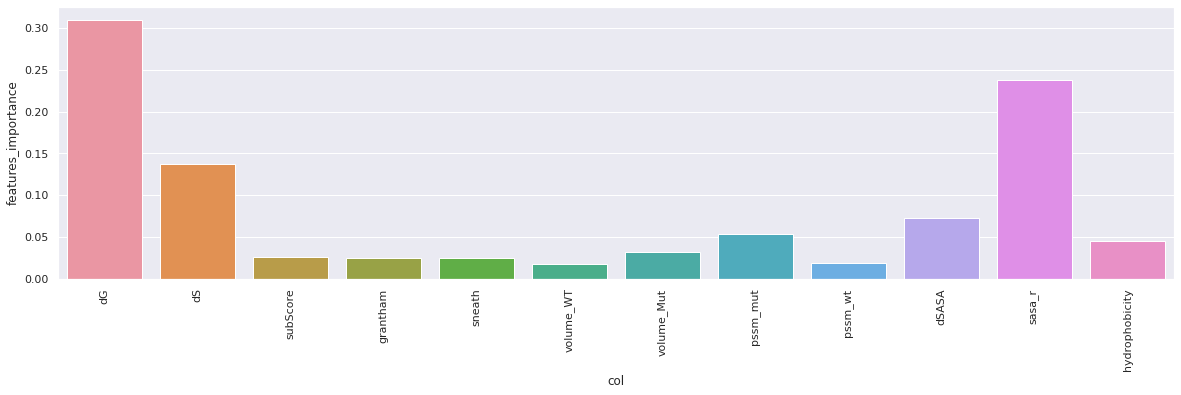

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from numpy.random import randint 

def testRFC(data):
    random_integer = randint(0,10000000)
    print("random integer: ", 842026)
    print("random integer used to build the model: ", random_integer)
    X_train,  X_test, y_train, y_test  = train_test_split(data , energy_class , random_state=842026)
    clf = RandomForestClassifier(n_estimators=1000, min_samples_split=2, warm_start=True, min_samples_leaf = 42, max_features='sqrt', max_depth =60, bootstrap=True )
    clf.fit(X_train, y_train)
    print("Training set score: {:.2f}".format(clf.score(X_train, y_train)))
    print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))
    y_perdicted = clf.predict(X_test)
    print( accuracy_score(y_test, y_perdicted)) 
    print( confusion_matrix(y_test, y_perdicted, normalize="true"))
    print( classification_report(y_test, y_perdicted))
    
    scores = cross_val_score(clf, data , energy_class, cv = 10)
    print("Average cross-validation score: {:.2f}".format(scores.mean()))
    print(scores)
    df = pd.DataFrame( )
    df['features_importance'] = clf.feature_importances_
    df['col'] = data.columns 
    return df, clf
    
    
mydf, model = testRFC(dataset)

sns.set(rc={'figure.figsize':(20,5.0)})
plt.xticks(rotation=90)

sns.barplot(mydf['col'], mydf['features_importance'])




In [70]:
import pickle
pickle.dump(model, open("swaat_rf.ML", 'wb'))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

In [11]:
X_train,  X_test, y_train, y_test  = train_test_split(dataset , energy_class , random_state=2125)

In [10]:
y_true

NameError: name 'y_true' is not defined

In [46]:
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip( X_train ,y_poly_pred), key=sort_axis)
X_train , y_poly_pred = zip(*sorted_zip)
plt.plot(X_train , y_poly_pred, color='m')
plt.show()

NameError: name 'x' is not defined

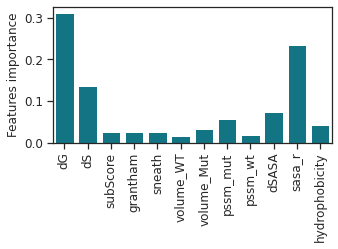

In [12]:
import matplotlib.pylab as plt 
sns.set(rc={'figure.figsize':(5,2.5)})

sns.set_style("ticks")
plt.xticks(rotation=90, size=12)
plt.yticks( size=12)


sns.barplot(mydf['col'], mydf['features_importance'], color="#008397ca")
plt.xlabel("")
plt.ylabel("Features importance")
plt.savefig("/home/houcemeddine/Desktop/feature_importance.svg")

In [20]:
dataset.to_csv("clean_training_and_test_dataset.csv", index=False)

In [14]:
model.predict(dataset)

array([1, 1, 1, ..., 1, 0, 1])

In [17]:
predict_log_proba(X)

NameError: name 'predict_log_proba' is not defined

In [18]:
dataset.shape

(2015, 12)

In [14]:
mydf.sort_values(by=["features_importance"])

,features_importance,col
5,0.015701,volume_WT
8,0.018122,pssm_wt
3,0.024737,grantham
2,0.026488,subScore
4,0.026689,sneath
6,0.033906,volume_Mut
11,0.043313,hydrophobicity
7,0.055958,pssm_mut
9,0.074417,dSASA
1,0.135536,dS


In [26]:
seq_based = mydf[mydf.col.isin(['dSASA', 'pssm_wt', "grantham", "subScore", "sneath", "volume_Mut", "hydrophobicity", "pssm_mut"  ])].sort_values(by=["features_importance"], ascending=False)
category = 2* np.ones(len(seq_based))

seq_based['category'] = category

In [34]:
struct_based = mydf[mydf.col.isin(['dSASA', 'dS', "sasa_r", "dG" ])].sort_values(by=["features_importance"], ascending=False)
category = 1* np.ones(len(struct_based))

struct_based['category'] = category

In [35]:
struct_based

,features_importance,col,category
0,0.310646,dG,1.0
10,0.234487,sasa_r,1.0
1,0.135536,dS,1.0
9,0.074417,dSASA,1.0


In [42]:
new_df = pd.concat([struct_based, seq_based ], sort=False)
new_df

,features_importance,col,category
0,0.310646,dG,1.0
10,0.234487,sasa_r,1.0
1,0.135536,dS,1.0
9,0.074417,dSASA,1.0
7,0.055958,pssm_mut,2.0
11,0.043313,hydrophobicity,2.0
6,0.033906,volume_Mut,2.0
4,0.026689,sneath,2.0
2,0.026488,subScore,2.0
3,0.024737,grantham,2.0


In [60]:
new_labels = [r"$\Delta \Delta$ G", r"$\frac{SASA_{var}}{SASA_{ref}}$" , r"$\Delta \Delta S$", "$\Delta SASA$", 
             "Variant PSSM score", "Hydrophobicity", "Variant residue volume", "Sneath's index", 
             "BLOSUM62 score", "Grantham's index", "Reference PSSM score", "Reference residue volume"  ]

In [62]:
new_df["labels"] = new_labels

In [63]:
new_df

,features_importance,col,category,labels
0,0.310646,dG,1.0,$\Delta \Delta$ G
10,0.234487,sasa_r,1.0,$\frac{SASA_{var}}{SASA_{ref}}$
1,0.135536,dS,1.0,$\Delta \Delta S$
9,0.074417,dSASA,1.0,$\Delta SASA$
7,0.055958,pssm_mut,2.0,Variant PSSM score
11,0.043313,hydrophobicity,2.0,Hydrophobicity
6,0.033906,volume_Mut,2.0,Variant residue volume
4,0.026689,sneath,2.0,Sneath's index
2,0.026488,subScore,2.0,BLOSUM62 score
3,0.024737,grantham,2.0,Grantham's index


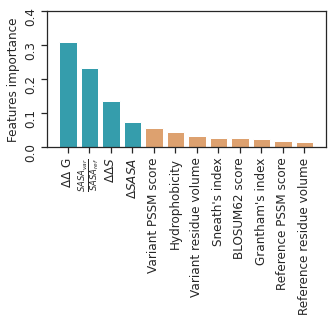

In [80]:
import matplotlib.pylab as plt 
sns.set(rc={'figure.figsize':(5,2.5)})

sns.set_style("ticks")
plt.xticks(rotation=90, size=12)
plt.yticks(rotation=90, size=12)

plt.yticks( size=12)

cat1 = new_df[new_df["category"] == 1] 
cat2 = new_df[new_df["category"] == 2] 

#colors = ["#008397ca"]*4+["#dda16fff"]*8
colors = [(0.2, 0.4, 0.6, 0.6)]*12
plt.bar(cat1['labels'], cat1['features_importance'], color="#008397ca")
plt.bar(cat2['labels'], cat2['features_importance'], color="#dda16fff")


plt.ylim(0, 0.4)
plt.xlabel("")
plt.ylabel("Features importance")
plt.savefig("/home/houcemeddine/BILIM/SWAAT_paper/figures/feature_importance.svg")



In [73]:
new_df[new_df["category"] == 1]

,features_importance,col,category,labels
0,0.310646,dG,1.0,$\Delta \Delta$ G
10,0.234487,sasa_r,1.0,$\frac{SASA_{var}}{SASA_{ref}}$
1,0.135536,dS,1.0,$\Delta \Delta S$
9,0.074417,dSASA,1.0,$\Delta SASA$
